### Clasiffication Pneumonia vs Normal with ChestX-ray (cell 2018)-Resnet34
DataSet: https://data.mendeley.com/datasets/rscbjbr9sj/2

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "/home/nbuser/chest_xray/"
sz=224

In [4]:
os.listdir(PATH)

['test',
 'valid',
 'models',
 '.ipynb_checkpoints',
 'train',
 'tmp',
 'ResNet34-ROC.ipynb',
 'Untitled.ipynb']

In [5]:
os.listdir(f'{PATH}valid')

['PNEUMONIA', 'NORMAL']

In [6]:
files = os.listdir(f'{PATH}valid/NORMAL')[:5]
files

['NORMAL2-IM-0300-0001.jpeg',
 'NORMAL2-IM-0102-0001.jpeg',
 'NORMAL2-IM-0201-0001.jpeg',
 'NORMAL2-IM-0120-0001.jpeg',
 'NORMAL2-IM-0199-0001.jpeg']

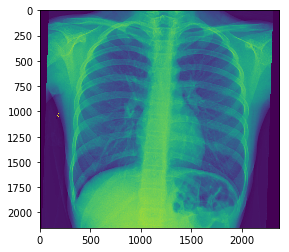

In [7]:
img = plt.imread(f'{PATH}valid/NORMAL/{files[1]}')
plt.imshow(img);

In [8]:
os.makedirs('/cache/tmp', exist_ok=True)
!ln -fs /cache/tmp {PATH}

In [9]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

100%|██████████| 10/10 [00:13<00:00,  1.33s/it]


epoch      trn_loss   val_loss   accuracy                  
    0      0.212252   0.581948   0.788462  
    1      0.144247   0.579838   0.807692                  



[array([0.57984]), 0.8076923076923077]

In [10]:
data.classes

['NORMAL', 'PNEUMONIA']

In [11]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [12]:
lrf=learn.lr_find()

 71%|███████   | 58/82 [00:01<00:00, 36.52it/s, loss=1.87] 


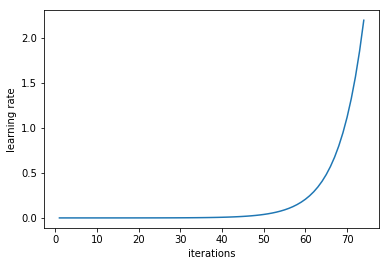

In [13]:
learn.sched.plot_lr()

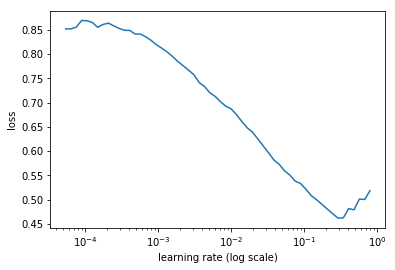

In [14]:
learn.sched.plot()

In [15]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [16]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [17]:
ims = np.stack([get_augs() for i in range(6)])

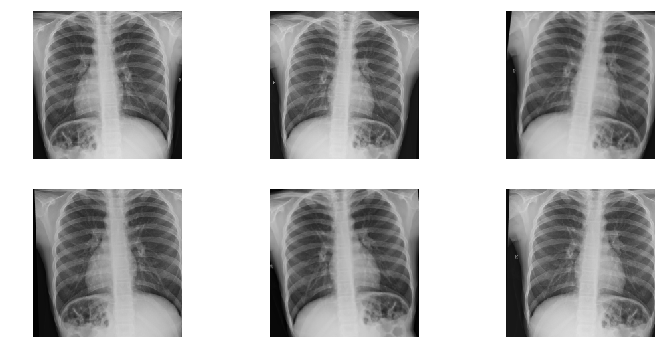

In [18]:
plots(ims, rows=2)

In [19]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [20]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.203598   0.470348   0.8125    



[array([0.47035]), 0.8124999984716758]

In [21]:
learn.precompute=False

In [22]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.171525   0.36557    0.841346  
    1      0.163267   0.367568   0.839744                  
    2      0.150206   0.388644   0.842949                  



[array([0.38864]), 0.842948717948718]

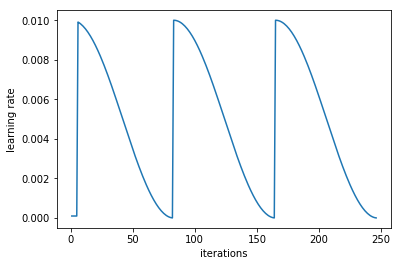

In [23]:
learn.sched.plot_lr()

In [24]:
learn.unfreeze()

In [25]:
lr=np.array([1e-4,1e-3,1e-2])

In [26]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.184295   0.406236   0.834936  
    1      0.124008   0.346926   0.886218                  
    2      0.096414   0.372817   0.862179                   
    3      0.095667   0.309934   0.895833                   
    4      0.075536   0.359725   0.889423                   
    5      0.068728   0.337434   0.897436                   
    6      0.067704   0.295721   0.913462                   



[array([0.29572]), 0.9134615399898627]

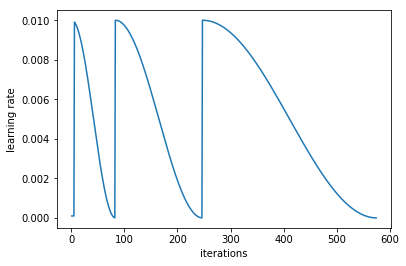

In [27]:
learn.sched.plot_lr()

In [28]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [29]:
accuracy_np(probs, y)

0.8782051282051282

In [31]:
probs[-10:]

array([[0.00026, 0.99974],
       [0.00133, 0.99867],
       [0.00862, 0.99138],
       [0.00162, 0.99838],
       [0.00531, 0.99469],
       [0.00294, 0.99706],
       [0.00111, 0.99889],
       [0.89045, 0.10955],
       [0.03713, 0.96287],
       [0.03435, 0.96565]], dtype=float32)

### Confusion Matrix

In [32]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [33]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[161  73]
 [  3 387]]


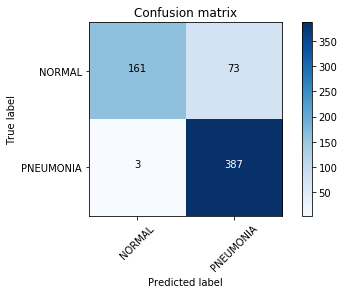

In [34]:
plot_confusion_matrix(cm, data.classes)

### ROC Curve

In [35]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y, probs)

In [36]:
from sklearn.metrics import auc
auc = auc(fpr, tpr)
print(auc)

0.972879684418146


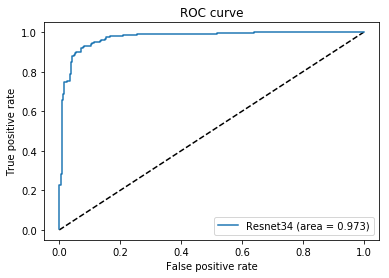

In [37]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Resnet34 (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [38]:
print(fpr)

[0.      0.      0.00427 0.00427 0.00855 0.00855 0.00855 0.00855 0.01282 0.01282 0.01709 0.01709 0.02137
 0.02137 0.02564 0.02564 0.03419 0.03419 0.03846 0.03846 0.04274 0.04274 0.04701 0.04701 0.05128 0.05128
 0.05556 0.05556 0.07265 0.07265 0.07692 0.07692 0.0812  0.0812  0.08547 0.08547 0.10256 0.10256 0.10684
 0.10684 0.11111 0.11111 0.11538 0.11538 0.11966 0.11966 0.13248 0.13248 0.13675 0.13675 0.14957 0.14957
 0.15385 0.15385 0.16667 0.16667 0.17949 0.17949 0.2094  0.2094  0.23077 0.23077 0.25641 0.25641 0.29915
 0.29915 0.51709 0.51709 0.61111 0.61111 0.64103 0.64103 1.     ]


In [39]:
print(tpr)

[0.00256 0.22564 0.22564 0.28462 0.28462 0.38462 0.38974 0.65897 0.65897 0.68718 0.68718 0.74615 0.74615
 0.74872 0.74872 0.75128 0.75128 0.78718 0.78718 0.84872 0.84872 0.87949 0.87949 0.88718 0.88718 0.89744
 0.89744 0.9     0.9     0.92051 0.92051 0.92564 0.92564 0.92821 0.92821 0.93077 0.93077 0.94103 0.94103
 0.94359 0.94359 0.94615 0.94615 0.94872 0.94872 0.95128 0.95128 0.95385 0.95385 0.96154 0.96154 0.96667
 0.96667 0.97692 0.97692 0.97949 0.97949 0.98205 0.98205 0.98462 0.98462 0.98718 0.98718 0.98974 0.98974
 0.99231 0.99231 0.99487 0.99487 0.99744 0.99744 1.      1.     ]


In [ ]:
probs[:5]

In [40]:
predict1 = []
for i in range(len(probs)):
    if probs[i] > 0.5:
        predict1.append(1)
    else:
        predict1.append(0)

In [41]:
len(predict1)

624

In [42]:
y_pred = np.array(predict1)

In [43]:
print(sklearn.metrics.classification_report(y_pred, y))

             precision    recall  f1-score   support

          0       0.69      0.98      0.81       164
          1       0.99      0.84      0.91       460

avg / total       0.91      0.88      0.88       624

